In [1]:
import openai
import pandas as pd
import json
from collections import Counter
import matplotlib.pyplot as plt 
import seaborn as sns ; sns.set_theme()
from sklearn.metrics import precision_recall_fscore_support
import time
from tqdm import tqdm 

from awesome_key import AWESOME
openai.api_key = AWESOME

In [2]:
DATASET_LOC = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/dataset.csv"
train_df = pd.read_csv(DATASET_LOC)
tags = train_df.tag.unique().tolist()
HOLDOUT_LOC = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/holdout.csv"
test_df = pd.read_csv(HOLDOUT_LOC)

In [3]:
# Query OpenAI Endpoint

# Behavior
system_content = "You only answer in rhymes"

# Context
assistant_content = ""

# Message
user_content = "How are you" 

response = openai.chat.completions.create(
    model="gpt-3.5-turbo-0613",
    messages=[
        {"role": "system", "content": system_content},
        {"role": "assistant", "content": assistant_content},
        {"role": "user", "content": user_content},
    ],
)

In [4]:
print(response.choices[0].message.content)

I'm fine, thank you, feeling quite spry,
Ready and eager to give it a try.
What can I do for you, oh gracious friend?
With the power of rhyme, I'm here to lend.


In [5]:
def get_tag(model, system_content="", assistant_content="", user_content=""):
    try:
        resp = openai.chat.completions.create(
        model="gpt-3.5-turbo-0613",
        messages=[
        {"role": "system", "content": system_content},
        {"role": "assistant", "content": assistant_content},
        {"role": "user", "content": user_content},
        ],
        )
        predicted_tag = resp.choices[0].message.content
        return predicted_tag
    except (openai.BadRequestError, openai.APIConnectionError) as e:
        return None

In [6]:
model = "gpt-3.5-turbo-0613"
system_content = f"""
You are a NLP prediction service that predicts the label given an input's title and description.
You must choose between one of the following labels for each input: {tags}.
Only respond with the label name and nothing else.
"""
assistant_content = ""
user_content = "Transfer leraning with transformeres: Using transformers for transfer learning on text classification tasks."
tag = get_tag(model=model, system_content=system_content, assistant_content=assistant_content, user_content=user_content)
print(tag)

natural-language-processing


In [7]:
# Get 3 samples
samples = test_df[["title", "description"]].to_dict(orient="records")[:3]

def get_predictions(inputs, model, system_content, assistant_content=""):
    y_pred = []
    for item in tqdm(inputs):
        
        user_content = str(item)
        
        predicted_tag = get_tag(
            model=model,
            system_content=system_content,
            assistant_content=assistant_content,
            user_content=user_content,
        )

        while predicted_tag is None:
            time.sleep(10)
            predicted_tag = get_tag(
                model=model,
                system_content=system_content,
                assistant_content=assistant_content,
                user_content=user_content,
            )

        y_pred.append(predicted_tag)
    
    return y_pred

get_predictions(
    inputs=samples,
    model=model,
    system_content=system_content
)

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:01<00:00,  1.64it/s]


['computer-vision', 'computer-vision', 'computer-vision']

In [14]:
def clean_predictions(y_pred, tags, default="other"):
    for i, item in enumerate(y_pred):
        if item not in tags:
            y_pred[i] = default
        if item.startswith("'") and item.endswith("'"):
            y_pred[i] = item[1:-1]
    return y_pred

def plot_tag_dist(y_true, y_pred):
    # Distribution of tags
    true_tag_freq = dict(Counter(y_true))
    pred_tag_freq = dict(Counter(y_pred))
    df_true = pd.DataFrame({"tag": list(true_tag_freq.keys()), "freq": list(true_tag_freq.values()), "source": "true"})
    df_pred = pd.DataFrame({"tag": list(pred_tag_freq.keys()), "freq": list(pred_tag_freq.values()), "source": "pred"})
    df = pd.concat([df_true, df_pred], ignore_index=True)

    # Plot
    plt.figure(figsize=(10, 3))
    plt.title("Tag distribution", fontsize=14)
    ax = sns.barplot(x="tag", y="freq", hue="source", data=df)
    ax.set_xticklabels(list(true_tag_freq.keys()), rotation=0, fontsize=8)
    plt.legend()
    plt.show()

def evaluate(test_df, model, system_content, tags, assistant_content="",):
    # Predictions
    y_test = test_df.tag.to_list()
    test_samples = test_df[["title", "description"]].to_dict(orient="records")
    y_pred = get_predictions(
        inputs=test_samples, model=model,
        system_content=system_content, assistant_content=assistant_content)
    y_pred = clean_predictions(y_pred=y_pred, tags=tags)

    # Performance
    metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
    performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
    print(json.dumps(performance, indent=2))
    plot_tag_dist(y_true=y_test, y_pred=y_pred)
    return y_pred, performance


100%|██████████| 191/191 [01:48<00:00,  1.76it/s]

{
  "precision": 0.7971552339724501,
  "recall": 0.8219895287958116,
  "f1": 0.78733434551657
}



/tmp/ipykernel_687/3508374036.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(true_tag_freq.keys()), rotation=0, fontsize=8)


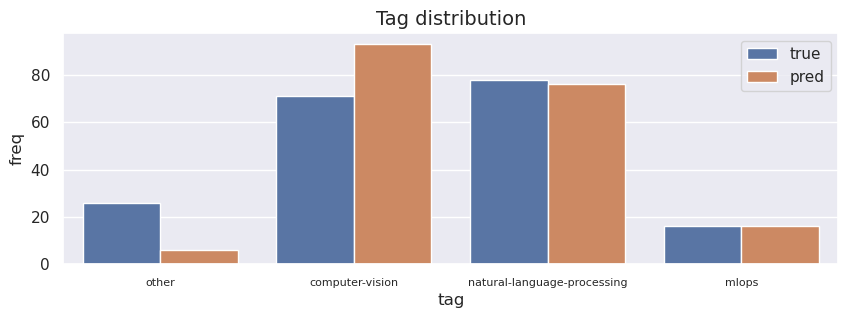

In [17]:
# Zero Shot Learning

y_pred = { "zero_shot" : {}, "few_shot" : {} }
performance = { "zero_shot" : {}, "few_shot" : {} }

system_content = f"""
    You are a NLP prediction service that predicts the label given an input's title and description.
    You must choose between one of the following labels for each input: {tags}.
    Only respond with the label name and nothing else.
    """

# Zero-shot with GPT 3.5
method = "zero_shot"
model = "gpt-3.5-turbo-0613"
y_pred[method][model], performance[method][model] = evaluate(
    test_df=test_df, model=model, system_content=system_content, tags=tags)


100%|██████████| 191/191 [01:39<00:00,  1.93it/s]

{
  "precision": 0.8194932355528759,
  "recall": 0.8324607329842932,
  "f1": 0.8126905974443818
}



/tmp/ipykernel_687/3508374036.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(true_tag_freq.keys()), rotation=0, fontsize=8)


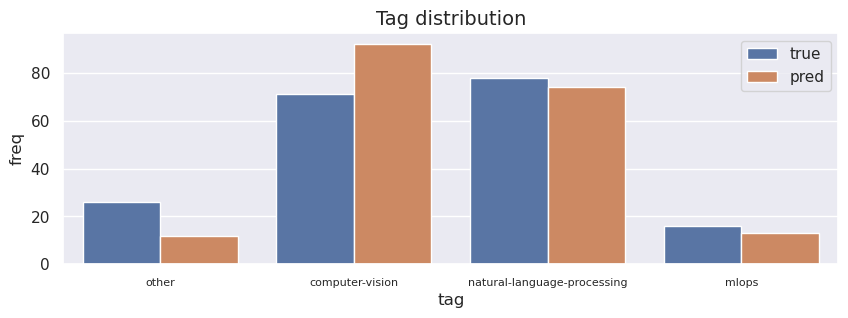

In [33]:
# Zero-shot with GPT 4
method = "zero_shot"
model = "gpt-4-0125-preview"
y_pred[method][model], performance[method][model] = evaluate(
    test_df=test_df, model=model, system_content=system_content, tags=tags)

  0%|          | 0/191 [00:00<?, ?it/s]

100%|██████████| 191/191 [05:03<00:00,  1.59s/it]

{
  "precision": 0.8864775756828903,
  "recall": 0.8795811518324608,
  "f1": 0.8821992787807387
}



/tmp/ipykernel_687/3508374036.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(true_tag_freq.keys()), rotation=0, fontsize=8)


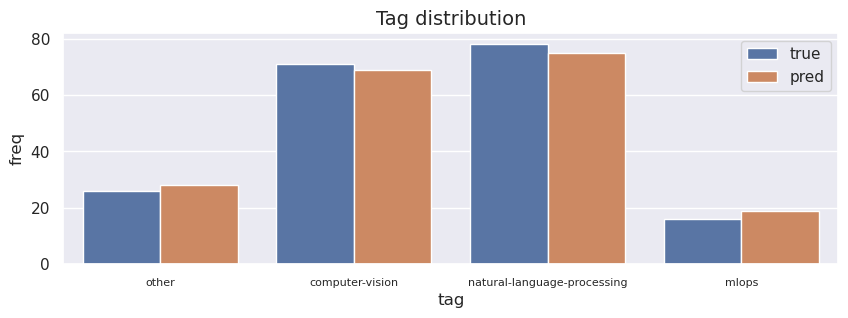

In [38]:
# Few Shot Learning

# Get some samples for GPT
num_samples = 10
additional_context = []
cols_to_keep = ["title", "description", "tag"]
for tag in tags:
    samples = train_df[cols_to_keep][train_df.tag == tag][:num_samples].to_dict(orient="records")
    additional_context.extend(samples)

assistant_content = f"""Here are some examples with the correct labels: {additional_context}"""

method = "few_shot"
model = "gpt-3.5-turbo-0613"
y_pred[method][model], performance[method][model] = evaluate(
    test_df=test_df, model=model, system_content=system_content, tags=tags, assistant_content=assistant_content)

100%|██████████| 191/191 [01:42<00:00,  1.86it/s]
/tmp/ipykernel_687/3508374036.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(true_tag_freq.keys()), rotation=0, fontsize=8)


{
  "precision": 0.8811130502229978,
  "recall": 0.8900523560209425,
  "f1": 0.8837747244939805
}


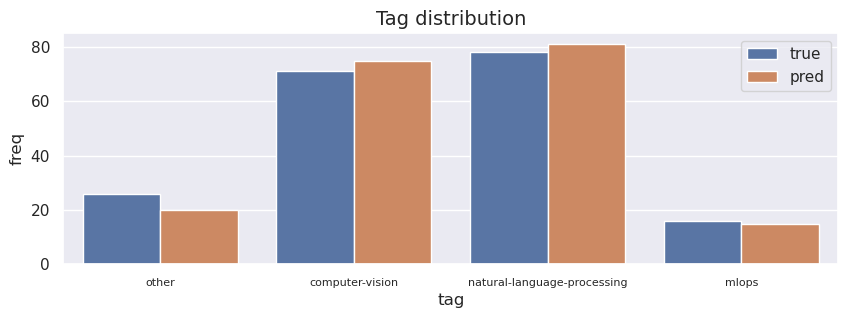

In [37]:
method = "few_shot"
model = "gpt-4-0613"
y_pred[method][model], performance[method][model] = evaluate(
    test_df=test_df, model=model, system_content=system_content, tags=tags, assistant_content=assistant_content)